# Определение перспективного тарифа для телеком-компании

**Описание тарифов:**

**Тариф «Смарт».**
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 
- минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
- сообщение: 3 рубля; 
- 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра».**
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 
- минута разговора: 1 рубль; 
- сообщение: 1 рубль; 
- 1 Гб интернет-трафика: 150 рублей.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

#### Описание данных

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Подготовка данных

#### Изменение типов данных

In [8]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

#### Исправление ошибочных данных

Удаление столбца 'Unnamed: 0':

In [9]:
internet = internet.drop('Unnamed: 0', 1)

#### Расчет дополнительных данных

Добавление столбцов с номером месяца:

In [10]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

internet['month'] = pd.DatetimeIndex(internet['session_date']).month

messages['month'] = pd.DatetimeIndex(messages['message_date']).month

Округление минут:

In [11]:
calls['duration'] = np.ceil(calls['duration'])

Необходимо посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

In [12]:
calls_grouped = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = ['count','sum'])
calls_grouped.columns = ['calls_count','calls_duration']

In [13]:
messages_grouped = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count')
messages_grouped.columns = ['message_count']

In [14]:
internet_grouped = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum')

После суммирования использованного интернет-трафика по месяцам, необходимо выполнить округление:

In [15]:
internet_grouped['gb_used'] = np.ceil(internet_grouped['mb_used']/1024)

Объединение таблиц с услугами:

In [16]:
data = calls_grouped.merge(internet_grouped, on = ['user_id','month'], how = 'outer')
data = data.merge(messages_grouped, on = ['user_id','month'], how = 'outer')
display(data)

calls_count  calls_duration   mb_used  gb_used  message_count
user_id month                                                               
1000    5             22.0           159.0   2253.49      3.0           22.0
        6             43.0           172.0  23233.77     23.0           60.0
        7             47.0           340.0  14003.64     14.0           75.0
        8             52.0           408.0  14055.93     14.0           81.0
        9             58.0           466.0  14568.91     15.0           57.0
...                    ...             ...       ...      ...            ...
1489    8              NaN             NaN  11050.56     11.0           17.0
        9              NaN             NaN  17206.30     17.0           32.0
        10             NaN             NaN  19559.44     20.0           21.0
        11             NaN             NaN  17491.56     18.0           20.0
        12             NaN             NaN  17322.51     17.0           35.0

[3214 rows x 5 columns]

При объединении таблиц внешним способом в общей таблице появляются пропущенные значения, то есть клиент не пользовался какой-либо услугой вообще. Пропуски в столбцах 'calls_count', 'calls_duration', 'mb_used' и 'message_count' заменяются на нули.

In [17]:
columns = ['calls_count', 'calls_duration', 'mb_used', 'message_count']

for column in columns:
    data[column] = data[column].fillna(0)

#### Расчет выручки с каждого пользователя

Для расчета выручки по месяцам для каждого клиента и для дальнейшего анализа необходимо добавить в таблицу столбцы с городом проживания клиента и с названием тарифа из таблицы 'users', а также все столбцы таблицы 'tariffs'.

In [18]:
data = data.merge(users[['user_id','city','tariff']], on = 'user_id', how = 'left')

tariffs = tariffs.rename(columns = {'tariff_name': "tariff"}) #Переименование столбца для объединения

data = data.merge(tariffs, on = 'tariff', how = 'left')

display(data.head(5))

,user_id,calls_count,calls_duration,mb_used,gb_used,message_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,22.0,159.0,2253.49,3.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,43.0,172.0,23233.77,23.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,47.0,340.0,14003.64,14.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,52.0,408.0,14055.93,14.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,58.0,466.0,14568.91,15.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


Для удобства расчета добавляются столбцы:
- с лимитом интернета в Гб;
- превышение минут сверх пакета для каждого клиента;
- превышение смс;
- превышение интернет-трафика.

In [19]:
data['gb_per_month_included'] = data['mb_per_month_included'] / 1024

In [20]:
data['minutes_over'] = data['calls_duration'] - data['minutes_included']

data['messages_over'] = data['message_count'] - data['messages_included']

data['gb_over'] = data['gb_used'] - data['gb_per_month_included']

Если какое-либо превышение меньше нуля, то есть клиент не вышел за рамки пакета - значение заменяется на ноль. 

In [21]:
columns = ['minutes_over', 'messages_over', 'gb_over']

for column in columns:
    data[column] = data[column].where(data[column] > 0, 0)

Выручка с каждого клиента по месяцам рассчитывается по формуле: 
 
revenue = rub_monthly_fee + (minutes_over * rub_per_minute) + (messages_over * rub_per_message) + (gb_over * rub_per_gb)


In [22]:
data['revenue'] = (data['rub_monthly_fee'] 
                   + (data['minutes_over'] * data['rub_per_minute']) 
                   + (data['messages_over'] * data['rub_per_message']) 
                   + (data['gb_over'] * data['rub_per_gb']))
display(data)

,user_id,calls_count,calls_duration,mb_used,gb_used,message_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,minutes_over,messages_over,gb_over,revenue
0,1000,22.0,159.0,2253.49,3.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950.0
1,1000,43.0,172.0,23233.77,23.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950.0
2,1000,47.0,340.0,14003.64,14.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950.0
3,1000,52.0,408.0,14055.93,14.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950.0
4,1000,58.0,466.0,14568.91,15.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,0.0,0.0,11050.56,11.0,17.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.0,0.0,0.0,0.0,550.0
3210,1489,0.0,0.0,17206.30,17.0,32.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.0,0.0,0.0,2.0,950.0
3211,1489,0.0,0.0,19559.44,20.0,21.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.0,0.0,0.0,5.0,1550.0
3212,1489,0.0,0.0,17491.56,18.0,20.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.0,0.0,0.0,3.0,1150.0


### Анализ данных

Необходимо описать поведение клиентов оператора: сколько минут разговора требуется пользователям каждого тарифа в месяц, сколько сообщений и какой объём интернет-трафика. Для отображения частот таких непрерывных величин на графике используется плотностная гистограмма.

In [23]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

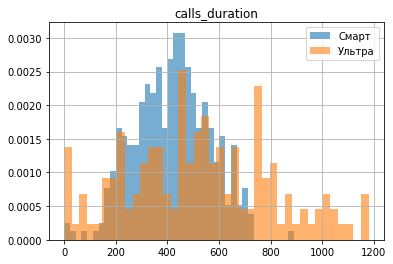

In [24]:
distr_smart = data_smart.pivot_table(index = 'user_id', values = 'calls_duration', aggfunc = 'mean')
distr_ultra = data_ultra.pivot_table(index = 'user_id', values = 'calls_duration', aggfunc = 'mean')

ax = distr_smart.hist(density = True, 
                      grid = True,
                      bins = 40,
                      alpha = 0.6)

distr_ultra.hist(density = True,
                 grid = True,
                 bins = 40,
                 alpha = 0.6, 
                 ax = ax);

plt.legend(['Смарт', 'Ультра']);

Распределение минут для клиентов тарифа "Смарт" - симметричное и близко к нормальному. Распределение для тарифа "Ультра" скошено вправо (количество значений справа от максимума больше, чем слева), а также имеются редкие сильно выбивающиеся значения.

В среднем пользователям тарифа "Ультра" требуется больше минут в месяц.

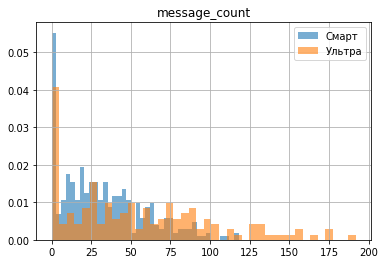

In [25]:
distr_smart = data_smart.pivot_table(index = 'user_id', values = 'message_count', aggfunc = 'mean')
distr_ultra = data_ultra.pivot_table(index = 'user_id', values = 'message_count', aggfunc = 'mean')

ax = distr_smart.hist(density = True, 
                      grid = True,
                      bins = 40,
                      alpha = 0.6)

distr_ultra.hist(density = True,
                 grid = True,
                 bins = 40,
                 alpha = 0.6, 
                 ax = ax);

plt.legend(['Смарт', 'Ультра']);

Большое количество пользователей обоих тарифов не пользуются услугой отправки смс. 
Плотностная гистограмма без учета нулевых значений:

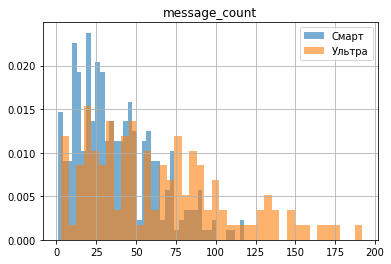

In [26]:
distr_smart = data_smart.pivot_table(index = 'user_id', values = 'message_count', aggfunc = 'mean')
distr_ultra = data_ultra.pivot_table(index = 'user_id', values = 'message_count', aggfunc = 'mean')

ax = distr_smart.query('message_count > 0').hist(density = True, 
                      grid = True,
                      bins = 40,
                      alpha = 0.6)

distr_ultra.query('message_count > 0').hist(density = True,
                 grid = True,
                 bins = 40,
                 alpha = 0.6, 
                 ax = ax);

plt.legend(['Смарт', 'Ультра']);

Оба распределения скошены вправо, но распределение для тарифа "Ультра" смещено вправа сильнее. Это означает, что те пользователи этого тарифа, которые вообще пользуются услугой смс, в среднем отправляют больше сообщений в месяц.

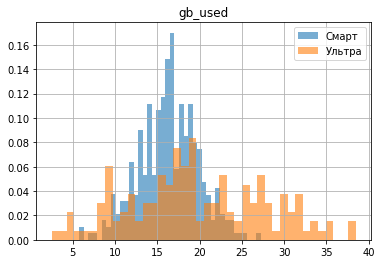

In [27]:
distr_smart = data_smart.pivot_table(index = 'user_id', values = 'gb_used', aggfunc = 'mean')
distr_ultra = data_ultra.pivot_table(index = 'user_id', values = 'gb_used', aggfunc = 'mean')

ax = distr_smart.hist(density = True, 
                      grid = True,
                      bins = 40,
                      alpha = 0.6)

distr_ultra.hist(density = True,
                 grid = True,
                 bins = 40,
                 alpha = 0.6, 
                 ax = ax);

plt.legend(['Смарт', 'Ультра']);

Оба распределения симметричны, но распределение для тарифа "Ультра" расположено правее, то есть в среднем пользователи этого тарифа тратят больше интернет-трафика в месяц.

Далее необходимо рассчитать характеристики полученных распределений распределений. 

In [31]:
data.pivot_table(index = 'tariff', values = ['calls_duration','message_count','gb_used'], aggfunc = ['mean','var','std'])

mean                                     var             \
       calls_duration    gb_used message_count calls_duration    gb_used   
tariff                                                                     
smart      417.934948  16.336176     33.384029   36219.315784  32.923756   
ultra      526.623350  19.694359     49.363452  100873.633397  94.146734   

                                std                          
       message_count calls_duration   gb_used message_count  
tariff                                                       
smart     796.812958     190.313730  5.737923     28.227876  
ultra    2285.266143     317.606098  9.702924     47.804457

**Вывод**

В среднем пользователи тарифа 'Ультра' тратят больше интернет-трафика и минут в месяц на звонки, а также отправляют больше смс. Стандартное отклонение и дисперсия для всех трех распределений также в разы больше для тарифа 'Ультра'.

### Проверка гипотез

Необходимо проверить гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Гипотеза о различии средней выручки пользователей двух тарифов

Нулевая гипотеза $ H_0 $: средняя выручка пользователей тарифов "Ультра" и "Смарт" равны.

Альтернативная гипотеза $ H_1 $: средняя выручка пользователей "Ультра" и "Смарт" не равны.

Для проверки гипотезы о равенстве средних используется t-тест. Его можно применить, так как размер двух выборок достаточно большой (обеспечивается нормальное распределение выборочных средних) и две генеральные совокупности независимы друг от друга (пользователи разных тарифов). Нельзя сказать о равенстве дисперсий генеральных совокупностей, поэтому при расчете параметру 'equal_var' передается значение 'False'.

In [33]:
st.ttest_ind(data_ultra['revenue'], data_smart['revenue'], equal_var = False).pvalue

4.2606313931076085e-250

Значение p-уровня значимости меньше любого из возможных пороговых значений $ \alpha $, значит есть основания отвергнуть нулевую гипотезу. Имеются значимые различия выручки тарифов "Смарт" и "Ультра".

In [34]:
data_ultra['revenue'].mean()

2070.1522842639592

In [35]:
data_smart['revenue'].mean()

1289.9735307312696

Среднее значение выручки на одного пользователя в месяц для тарифа "Ультра" больше, чем для тарифа "Смарт".

#### Гипотеза о различии средней выручки пользователей из Москвы и из других регионов

Нулевая гипотеза $ H_0 $: средняя выручка пользователей из Москвы и других регионов равны.

Альтернативная гипотеза $ H_1 $: средняя выручка пользователей из Москвы и других регионов не равны.

Аналогично п.4.1 для проверки гипотезы о равенстве средних используется t-тест. 

In [36]:
data_moscow = data.query('city == "Москва"')
data_region = data.query('city != "Москва"')

In [37]:
st.ttest_ind(data_moscow['revenue'], data_region['revenue'], equal_var = False).pvalue

0.5257376663729298

Значение p-уровня значимости больше любого из возможных пороговых значений $ \alpha $, значит оснований отвергнуть нулевую гипотезу нет. Значимой разницы в выручке от пользователей из Москвы и других регионов нет.